In [1]:
from cobra.io import read_sbml_model
from collections import defaultdict
from Bio import Entrez, SeqIO
import re
import time
from Bio import pairwise2


model = read_sbml_model('iCGB21FR.xml')

SBML package 'layout' not supported by cobrapy, information is not parsed
https://juser.fz-juelich.de/record/188973 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id


The issue with the model "iCGB21FR.xml" is that its authors have named the genes in the following format **"lcl_{locus}_prot_{protein_id}_{unknown_digits}"**. An exemple name of the genes from the model would look like this: lcl_NC_006958_1_prot_WP_003859586_1_2138

In which **"NC_006958"** is the locus represent the complete sequence of Corynebacterium glutamicum ATCC 13032, and **WP_XXXXXXXXX** represent the protein_id of its genes.


**This results in adding an extra step of finding the gene name for the concerned protein ids.**


# Mapping:
- reaction -> genes
- gene -> reactions

In [2]:
print(f"{len(model.reactions)} reactions in 'iCGB21FR' model")
print(f"{len(model.genes)} genes in 'iCGB21FR' model")

1539 reactions in 'iCGB21FR' model
805 genes in 'iCGB21FR' model


In [3]:
reaction_to_genes = {}
gene_to_reactions = {}

def mapReactionToGenes():    
    for reaction in model.reactions:
        gene_ids = []
        for gene in reaction.genes:
            gene_ids.append(gene.id)
            
        reaction_to_genes[reaction.id] = gene_ids

def mapGeneToReactions():
    for reaction_id, gene_ids in reaction_to_genes.items():
        for gene_id in gene_ids:
            if gene_id:
                if gene_id not in gene_to_reactions:
                    gene_to_reactions[gene_id] = [reaction_id]
                else:
                    gene_to_reactions[gene_id].append(reaction_id)
    
mapReactionToGenes()
mapGeneToReactions()

In [4]:
print(f"{len(reaction_to_genes)} reactions are mapped in total")

reactions_coded_by_genes = 0
for reaction, genes in list(reaction_to_genes.items()):
    if len(genes) > 0:
        reactions_coded_by_genes +=1
print(f"{reactions_coded_by_genes} reactions have a genetic component (coded by at least one gene)\n")

print("   ...")
for reaction, genes in list(reaction_to_genes.items())[15:25]:
    print(f"{reaction} -> ")
    for gene in genes:
        print(f"    {gene}")
print("   ...")

1539 reactions are mapped in total
1077 reactions have a genetic component (coded by at least one gene)

   ...
2AGPG141tipp -> 
2AGPGAT141 -> 
2HH24DDH -> 
2MAHMP -> 
    lcl_NC_006958_1_prot_WP_011015468_1_2761
    lcl_NC_006958_1_prot_WP_003855288_1_2949
2PGLYCt6 -> 
3HAD140 -> 
3MBt2pp -> 
    lcl_NC_006958_1_prot_WP_011013917_1_810
3MBt4pp -> 
    lcl_NC_006958_1_prot_WP_011013917_1_810
3MBtex -> 
3OADPCOAT -> 
   ...


In [5]:
print(f"\n{len(gene_to_reactions)} genes are mapped in total\n")

for gene, reactions in list(gene_to_reactions.items())[:5]:
    print(f"{gene} ->")
    for reaction in reactions:
        print(f"    {reaction}")
print("   ...")


805 genes are mapped in total

lcl_NC_006958_1_prot_WP_011015468_1_2761 ->
    2MAHMP
    PDXPP
    PYDXPP
lcl_NC_006958_1_prot_WP_003855288_1_2949 ->
    2MAHMP
    TDP
lcl_NC_006958_1_prot_WP_011013917_1_810 ->
    3MBt2pp
    3MBt4pp
    ACt2rpp
    ACt4pp
    BUTt2rpp
    BUTt4pp
    GLYCLTt4pp
    PACt3
    PNTOt2
    PPAt2pp
    PPAt4pp
    PYRt2rpp
    PYRt4pp
lcl_NC_006958_1_prot_WP_003859251_1_2275 ->
    3OXCOAT
    ACACT1r
    ACACT2r
lcl_NC_006958_1_prot_WP_011015386_1_2669 ->
    4ABUTD
    ALDD2x
    ALDD2y
    ALDD31
    ALDD3y
    GLXO1
    GLYALDDr
    LCADi
   ...


In [6]:
gene_to_reactions_counts = defaultdict(list)

for gene, reactions in gene_to_reactions.items():
    gene_to_reactions_counts[len(reactions)].append((gene, reactions))

sorted_counts = sorted(gene_to_reactions_counts.items(), key=lambda x: x[0])

for count, gene_to_reactions_data in sorted_counts:
    reaction_str = "reaction" if count == 1 else "reactions"
    print(f"{len(gene_to_reactions_data)} genes control {count} {reaction_str}")

513 genes control 1 reaction
149 genes control 2 reactions
51 genes control 3 reactions
25 genes control 4 reactions
12 genes control 5 reactions
19 genes control 6 reactions
6 genes control 7 reactions
4 genes control 8 reactions
5 genes control 9 reactions
5 genes control 10 reactions
4 genes control 11 reactions
4 genes control 13 reactions
1 genes control 14 reactions
2 genes control 15 reactions
1 genes control 21 reactions
1 genes control 22 reactions
3 genes control 23 reactions


### Getting the gene data from the RefSeq database based on its protein ID

Fetching every protein Id in **gene_to_reactions** and returning the data for its gene: gene_name, product, organism, sequence.

The data is stored locally in **protein_id_to_gene_map** for future use, avoiding searching every time.

In [7]:
import re
from Bio import Entrez, SeqIO
import time
import json

def getFullGeneName(protein_id):
    for gene in model.genes:
        if protein_id in gene.id:
            return gene
        
def getProteinID(full_gene):
    """
    Function to get protein ID from a full gene name
    
    """
    return "WP_" + re.search(r"WP_(\d{9})", full_gene).group(1) if re.search(r"WP_(\d{9})", full_gene) else None


def fetchProteinID(protein_id, max_retries=50, delay_between_retries=1):
    """
    Function to fetch protein ID data
    
    """
    for attempt in range(max_retries):
        try:
            Entrez.email = "h.bensaadi@gmail.com"

            handle = Entrez.efetch(db="protein", id=protein_id, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()

            gene_name, product, organism, sequence = None, None, None, None

            for feature in record.features:
                if 'gene' in feature.qualifiers:
                    gene_name = feature.qualifiers['gene'][0]
                if 'product' in feature.qualifiers:
                    product = feature.qualifiers['product'][0]
                if 'organism' in feature.qualifiers:
                    organism = feature.qualifiers['organism'][0]

            sequence = str(record.seq)

            return protein_id, gene_name, product, organism, sequence

        except Entrez.HTTPError as e:
            if attempt < max_retries - 1:
                print(f"{protein_id}: retrying in {delay_between_retries} seconds...")
                time.sleep(delay_between_retries)
            else:
                print(f"Max retries reached. Unable to fetch data for {protein_id}")
                raise
        except Exception as e:
            print(f"Error: {e}")
            raise

def loadMapFile():
    try:
        with open("protein_id_to_gene_map.json", "r") as file:
            protein_id_to_gene_map = json.load(file)
    except FileNotFoundError:
        protein_id_to_gene_map = {}
    
    return protein_id_to_gene_map
    
def updateMapFile(protein_id_to_gene_map):
    with open("protein_id_to_gene_map.json", "w") as file:
        json.dump(protein_id_to_gene_map, file)
           
            
def getUniqueGeneNumber():
    unique_protein_ids = []
    
    for gene, reactions in list(gene_to_reactions.items()):
        if getProteinID(gene) not in unique_protein_ids:
            unique_protein_ids.append(getProteinID(gene))
    return len(unique_protein_ids)
    
def mapProteinIDtoGene():
    global protein_id_to_gene_map
    protein_id_to_gene_map = loadMapFile()

    print(f"{getUniqueGeneNumber()} protein ids to fetch their data")
    
    count_found_genes = 0
    for gene, reactions in list(gene_to_reactions.items()):
        if "WP_" in gene:
            protein_id = getProteinID(gene)

            if protein_id not in protein_id_to_gene_map:
                protein_id, gene_name, product, organism, sequence = fetchProteinID(protein_id)
                protein_id_to_gene_map[protein_id] = [gene_name, product, organism, sequence]
                updateMapFile(protein_id_to_gene_map)
                count_found_genes +=1
                
                print(f"\n{protein_id}, {gene_name}, {product}, {organism}, {sequence}")

    print(f"{count_found_genes} protein IDs were fetched online")
    print(f"{len(protein_id_to_gene_map)+1} protein IDs are stored locally")
     
mapProteinIDtoGene()

for protein_id, protein_data in list(protein_id_to_gene_map.items())[21:23]:
    print(f"\n{protein_id} ->")
    gene_name, product, organism, sequence = protein_data
    print(f"    {gene_name}")
    print(f"    {product}")
    print(f"    {organism}")
    print(f"    {sequence[:70]}...")
print("   ...")

786 protein ids to fetch their data
0 protein IDs were fetched online
786 protein IDs are stored locally

WP_011014763 ->
    ptsP
    phosphoenolpyruvate--protein phosphotransferase
    Corynebacterium glutamicum
    MATVADVNQDTVLKGTGVVGGVRYASAVWITPRPELPQAGEVVAEENREAEQERFDAAAATVSSRLLERS...

WP_003858695 ->
    argB
    acetylglutamate kinase
    Corynebacterium
    MNDLIKDLGSEVRANVLAEALPWLQHFRDKIVVVKYGGNAMVDDDLKAAFAADMVFLRTVGAKPVVVHGG...
   ...


### Serching the protein ID of a known gene 
The locally stored **protein_id_to_gene_map** are used to search for the **gene name** or its **sequence**

In [8]:
def calculate_similarity(seq1, seq2):
    alignments = pairwise2.align.globalxx(seq1, seq2, one_alignment_only=True)
    if alignments:
        alignment = alignments[0]
        alignment_length = max(len(alignment[0]), len(alignment[1]))
        similarity = alignment[2] / alignment_length
        return similarity
    return 0

def searchGene(gene=None, reaction=None, seq=None, similarity_threshold=0.80):
    matches = []
    
    protein_id_to_gene_map = loadMapFile()

    for protein_id, data in protein_id_to_gene_map.items():
        gene_name, product, organism, sequence = data
        
        if gene and gene_name and gene.lower() in gene_name.lower():
            matches.append((protein_id, data))
        
        if reaction and product and reaction.lower() in product.lower():
            matches.append((protein_id, data))
        
        if seq and sequence:
            similarity = calculate_similarity(seq.lower(), sequence.lower())            
            if similarity >= similarity_threshold:
                matches.append((protein_id, f"Similarity: {round(similarity*100, 2)}%", data))
    
    print(f"{len(matches)} match(es) were found:")
    return matches

def getDataFromProtreinID(searched_protein_id):
    protein_id_to_gene_map = loadMapFile()
    for protein_id, data in protein_id_to_gene_map.items():
        if searched_protein_id == protein_id:
            return data

def getGeneNameFromProteinID(searched_protein_id):
    for gene, reactions in list(gene_to_reactions.items()):
        if searched_protein_id == getProteinID(gene):
            return gene
    
def getReactionsFromProteinID(searched_protein_id):
    for gene, reactions in list(gene_to_reactions.items()):
        if searched_protein_id == getProteinID(gene):
            return reactions
    

## 1. replicating the results of an existing paper (Becker et al. 2011)

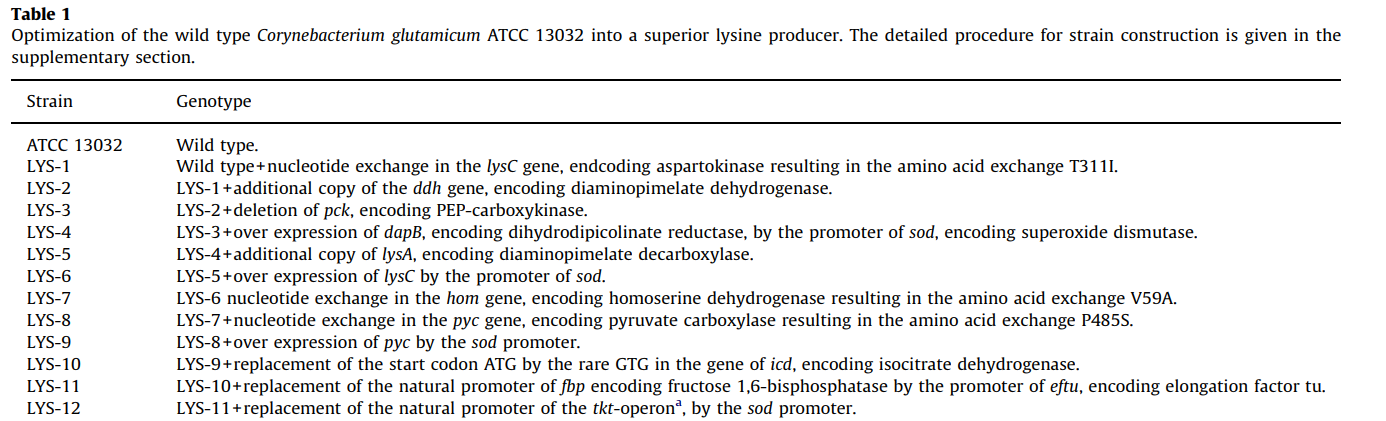

### 1. Direct search through the collected list of annoctated genes:

In [9]:
for g in ["lysC", "ddh", "pck", "dapB", "lysA", "hom", "pyc", "icd", "fbp", "tkt"]:
    print(f"\n{g}:")
    for match in searchGene(g):
        print(f"{match}")


lysC:
0 match(es) were found:

ddh:
0 match(es) were found:

pck:
0 match(es) were found:

dapB:
1 match(es) were found:
('WP_011014794', ['dapB', '4-hydroxy-tetrahydrodipicolinate reductase', 'Corynebacterium glutamicum', 'MGIKVGVLGAKGRVGQTIVAAVNESDDLELVAEIGVDDDLSLLVDNGAEVVVDFTTPNAVMGNLEFCINNGISAVVGTTGFDDARLEQVRDWLEGKDNVGVLIAPNFAISAVLTMVFSKQAARFFESAEVIELHHPNKLDAPSGTAIHTAQGIAAARKEAGMDAQPDATEQALEGSRGASVDGIPVHAVRMSGMVAHEQVIFGTQGQTLTIKQDSYDRNSFAPGVLVGVRNIAQHPGLVVGLEHYLGL'])

lysA:
1 match(es) were found:
('WP_011014180', ['lysA', 'diaminopimelate decarboxylase', 'Corynebacterium glutamicum', 'MATVENFNELPAHVWPRNAVRQEDGVVTVAGVPLPDLAEEYGTPLFVVDEDDFRSRCRDMATAFGGPGNVHYASKAFLTKTIARWVDEEGLALDIASINELGIALAAGFPASRITAHGNNKGVEFLRALVQNGVGHVVLDSAQELELLDYVAAGEGKIQDVLIRVKPGIEAHTHEFIATSHEDQKFGFSLASGSAFEAAKAANNAENLNLVGLHCHVGSQVFDAEGFKLAAERVLGLYSQIHSELGVALPELDLGGGYGIAYTAAEEPLNVAEVASDLLTAVGKMAAELGIDAPTVLVEPGRAIAGPSTVTIYEVGTTKDVHVDDDKTRRYIAVDGGMSDNIRPALYGSEYDARVVSRFAEGDPVSTRIVGSHCESGDILINDEIYPSDITSGDFLALAATG

### 2. Searching through AA sequence homology:

In [10]:
import requests

def getDataBasedOnTaxonomy():
    global data_from_taxonomy_search
    
    data_from_taxonomy_search = []
    
    taxonomy_codes = {
        "cgl": "Corynebacterium glutamicum ATCC 13032 (Kyowa Hakko)",
        "cgb": "Corynebacterium glutamicum ATCC 13032 (Bielefeld)",
        "cgu": "Corynebacterium glutamicum K051",
        "cgt": "Corynebacterium glutamicum R",
        "cgs": "Corynebacterium glutamicum SCgG1",
        "cgg": "Corynebacterium glutamicum SCgG2",
        "cgm": "Corynebacterium glutamicum MB001",
        "cgj": "Corynebacterium glutamicum ATCC 21831",
        "cgq": "Corynebacterium glutamicum AR1",
        "cgx": "Corynebacterium glutamicum B253"}

    for taxonomy_code in taxonomy_codes:
        search_url = f"http://rest.kegg.jp/find/genes/{taxonomy_code}"

        try:
            print(f"Getting data for {taxonomy_codes[taxonomy_code]}")
            response = requests.get(search_url)
            if response.status_code == 200:
                data_from_taxonomy_search.append(response.text.split('\n'))
            else:
                print(f"Error: {response.status_code}")
        except requests.exceptions.RequestException as e:
            print(f"Request Exception: {e}")
      
            
def getAminoAcidsSequence(gene_id):
    response = requests.get(f"http://rest.kegg.jp/get/{gene_id}")
    
    if response.status_code == 200:        
        lines = response.text.split('\n')
        amino_acid_sequence = ""
        is_aa_sequence_section = False

        for line in lines:
            if line.startswith("AASEQ"):
                is_aa_sequence_section = True
            elif line.startswith("NTSEQ"):
                is_aa_sequence_section = False
            elif is_aa_sequence_section and line.strip(): 
                amino_acid_sequence += line.strip()
        return amino_acid_sequence

    else:
        return f"Error: {response.status_code}"

In [11]:
getDataBasedOnTaxonomy()

print('Found results: \n')

found_results = {}

for gene_name_to_search in ["lysC", "ddh", "pck", "pyc", "icd", "fbp", 'hom;']:
    for data in data_from_taxonomy_search:
        for entry in data:
            if gene_name_to_search in entry:
                if gene_name_to_search not in found_results:
                    found_results[gene_name_to_search] = [entry]
                else:
                    found_results[gene_name_to_search].append(entry)
                            
    print(f"{gene_name_to_search}: {len(found_results[gene_name_to_search])} results")

aa_sequence_results = {}

for gene_name, entries in list(found_results.items()):
    for entry in entries:
        gene_id_kegg = entry.split("; ")[0].split("\t")[0]
        gene_name_kegg = entry.split("; ")[0].split("\t")[1]
        try:
            gene_description_kegg = entry.split("; ")[1]
        except:
            pass
        
        print(f"\nAA sequence for {gene_name_kegg}: {gene_id_kegg}")
        aa_seq = getAminoAcidsSequence(gene_id_kegg)
        
        print(aa_seq)
        
        if gene_name not in aa_sequence_results:
            aa_sequence_results[gene_name] = [{"kegg_id": gene_id_kegg, "aa_seq": aa_seq}]
        else:
            aa_sequence_results[gene_name].append({"kegg_id": gene_id_kegg, "aa_seq": aa_seq})

for gene_id, data in list(aa_sequence_results.items()):    
    for element in data:
        print(f'Searching {gene_id} -> {element["kegg_id"]}: \n')
        for match in searchGene(seq= element["aa_seq"], similarity_threshold=0.65):
            print(match)

Getting data for Corynebacterium glutamicum ATCC 13032 (Kyowa Hakko)
Getting data for Corynebacterium glutamicum ATCC 13032 (Bielefeld)
Getting data for Corynebacterium glutamicum K051
Getting data for Corynebacterium glutamicum R
Getting data for Corynebacterium glutamicum SCgG1
Getting data for Corynebacterium glutamicum SCgG2
Getting data for Corynebacterium glutamicum MB001
Getting data for Corynebacterium glutamicum ATCC 21831
Getting data for Corynebacterium glutamicum AR1
Getting data for Corynebacterium glutamicum B253
Found results: 

lysC: 2 results
ddh: 2 results
pck: 3 results
pyc: 2 results
icd: 2 results
fbp: 11 results

AA sequence for lysC: cgb:cg0306
MALVVQKYGGSSLESAERIRNVAERIVATKKAGNDVVVVCSAMGDTTDELLELAAAVNPVPPAREMDMLLTAGERISNALVAMAIESLGAEAQSFTGSQAGVLTTERHGNARIVDVTPGRVREALDEGKICIVAGFQGVNKETRDVTTLGRGGSDTTAVALAAALNADVCEIYSDVDGVYTADPRIVPNAQKLEKLSFEEMLELAAVGSKILVLRSVEYARAFNVPLRVRSSYSNDPGTLIAGSMEDIPVEEAVLTGVATDKSEAKVTVLGISDKPGEAAKVFRALADAEINIDMVLQNVSSVEDGTTDITFTCPRSDGRRAME

MSPTPRRLAATAAALAVLANAFPAAAQSSSPLHDAVALSSQTSASSTGSAVGSAASAVDAVGSARSSVPGAWVMPGSGKYPLPTDEGIVVPEVLAIEPDVGINVQKWSVASPAMKRVVQVQVRPAPEGAGAAPMLYLLDGVEATHPSDWIMLGHVDTKLRDDSVTLVMPTEARASMWADWYADDEVGGRHQWETFLTEELPPLLEDPAHGLDFNGKRGIGGISMGATGALAIANRNPDLFDAVFGISGCYSTTESLAAISNYLTVETRKNDFDNLYGPPGDWRWRHYDTEADPTGLADMTVYLSSARGVTQASSADHADADLINYVTGTVIEQATLVCTENLDAAMRTRGMAHQRVDYVEDGLHNWRNFHRFIEPAWEHIAPALEASP

AA sequence for fbpA5: cgf:CGUA_09355
MSRFTHRSLPSVLALGASAFLLAACAEPAEDNAASTSGSAAEGETVTLTVYTSEPEAKVDEINRAFMEANPDIEVEVYRAGTGDLNARIATEKETGTIGADVLWAADAPTFEGYAESGDLAELQDVNTDGIIDEAVDEEGYYVGTRIIPTVIAYNTDVMEQDQLPASWADLTDPKYRDQIVMPDPAVSGAAAFNASAWKNNEDLGEEWIIALGENNPMIAASNGPTSQEIAGGGHPLGVVVDYLVRDLAAEGSPIEVIYPTDGVPYITEPAGVFADSENQEAAERYINFLLSKEGQELAVEQNYLPVREDVGTPAGTPALADTALMEMDLDTIIADQANAVEVFQKAMQ

AA sequence for fbpA6: cgf:CGUA_10100
MRRSLTTVIATAVLAAAVTPAAAAQSSDPGLEAVALSSQQTEAVDAALFATLDAAETLDLTQPRFPSQLTSSDPSAPAPAAQPITEAAIVDKQVEDAAARLERWTVASPSMGRDVEIQIIRAVDPAAPAPHVYLLGGAESPRVSHWVSEGWAPEVFAHEQATVIMPTQAYASFYSDWRADDPV

1 match(es) were found:
('WP_011013800', 'Similarity: 65.8%', [None, 'NADP-dependent isocitrate dehydrogenase', 'Corynebacterium glutamicum', 'MAKIIWTRTDEAPLLATYSLKPVVEAFAATAGIEVETRDISLAGRILAQFPERLTEDQKVGNALAELGELAKTPEANIIKLPNISASVPQLKAAIKELQDQGYDIPELPDNATTDEEKDILARYNAVKGSAVNPVLREGNSDRRAPIAVKNFVKKFPHRMGEWSADSKTNVATMDANDFRHNEKSIILDAADEVQIKHIAADGTETILKDSLKLLEGEVLDGTVLSAKALDAFLLEQVARAKAEGILFSAHLKATMMKVSDPIIFGHVVRAYFADVFAQYGEQLLAAGLNGENGLAAILSGLESLDNGEEIKAAFEKGLEDGPDLAMVNSARGITNLHVPSDVIVDASMPAMIRTSGHMWNKDDQEQDTLAIIPDSSYAGVYQTVIEDCRKNGAFDPTTMGTVPNVGLMAQKAEEYGSHDKTFRIEADGVVQVVSSNGDVLIEHDVEANDIWRACQVKDAPIQDWVKLAVTRSRLSGMPAVFWLDPERAHDRNLASLVEKYLADHDTEGLDIQILSPVEATQLSIDRIRRGEDTISVTGNVLRDYNTDLFPILELGTSAKMLSVVPLMAGGGLFETGAGGSAPKHVQQVQEENHLRWDSLGEFLALAESFRHELNNNGNTKAGVLADALDKATEKLLNEEKSPSRKVGEIDNRGSHFWLTKFWADELAAQTEDADLAATFAPVAEALNTGAADIDAALLAVQGGATDLGGYYSPNEEKLTNIMRPVAQFNEIVDALKK'])
Searching fbp -> cgf:CGUA_01390: 

0 match(es) were found:
Searching fbp -> cgf:CGUA_05650: 

0 match(es) were foun

## 3. Manual search of "fbp": 

In [12]:
for metabolite in model.metabolites.query("D-Fructose 1-phosphate", "name"):
    print(f"Metabolite ID for D-Fructose 1-phosphate is: {metabolite}")
    print("The reactions involving D-Fructose 1-phosphate  are:")
    for reaction in model.metabolites.f1p_c.reactions:
        print(f"\t- {reaction.id} -> {reaction.reaction}")

Metabolite ID for D-Fructose 1-phosphate is: f1p_c
The reactions involving D-Fructose 1-phosphate  are:
	- FRUptspp -> fru_p + pep_c --> f1p_c + pyr_c
	- FRUK -> atp_c + f1p_c --> adp_c + fdp_c + h_c
	- FRUpts -> fru_e + pep_c --> f1p_c + pyr_c


In [13]:
model.reactions.FRUK 

Reaction identifier,FRUK
Name,Fructose-1-phosphate kinase
Memory address,0x16c2bb28a30
Stoichiometry,"atp_c + f1p_c --> adp_c + fdp_c + h_c ATP + D-Fructose 1-phosphate --> ADP + D-Fructose 1,6-bisphosphate + H+"
GPR,lcl_NC_006958_1_prot_WP_011014765_1_1834
Lower bound,0.0
Upper bound,1000.0


# Summary:

**Found through direct search:**

- dapB = 'WP_011014794'
- lysA = 'WP_011014180'
- tkt = 'WP_011014456'

**Found through AA sequence homology search:**

- lysC = 'WP_003855724', 'Similarity: 100.0%'
- ddh  = 'WP_011015446', 'Similarity: 66.49%'
- pck  = 'WP_011013816', 'Similarity: 100.0%'
- pyc  = 'WP_011013816', 'Similarity: 100.0%'
- icd  = 'WP_011013800', 'Similarity: 100.0%'
- hom  = 'WP_003854900', 'Similarity: 100.0%'

**Found through manual search:**

- fbp  = 'WP_011014765'


In [126]:
genes = {
    'dapB':'WP_011014794',
    'lysA': 'WP_011014180',
    'tkt': 'WP_011014456',
    'lysC': 'WP_003855724',
    'ddh' : 'WP_011015446',
    'pck': 'WP_011013816',
    'pyc' : 'WP_011013816', 
    'icd': 'WP_011013800',
    'hom' : 'WP_003854900', 
    'fbp' : 'WP_011014765'
}

## Implementing the genetic changes:
- LYS1: the mutation realsed **lysC** from the feedback inhibition => **skipped because it is a protein regulation**
- LYS2: having a second copy of **ddh** =>  **implemented by doubling the flux of PPCK and PEPCK_re** 
- LYS3: knockout of **pck** => **implemented by knocking out pck**
- LYS4: over expression of **dapB** =>
- LYS5: additional copy of **lysA** =>
- LYS6: over expression of **lysC** =>
- LYS7: leaky variant of **hom** gene =>
- LYS8-9: imporoving  the activity of **pyc** =>
- LYS10: overexpression of FBPase **fbp**  =>  
- LYS11: overexpression  **tkt** =>


### Main model

In [128]:
model.objective = model.reactions.DAPDC

solution = model.optimize()
print(f'Flux through DAPDC reaction is: {round(solution["DAPDC"], 4)} mmol/gDW*h')
solution

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,8.673617e-19
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,6.938894e-18
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,0.000000e+00
CYTB1,20.0,1.214306e-17
EX_34dhbz_e,0.0,0.000000e+00


### LYS2: having a second copy of ddh 

In [129]:
getFullGeneName(genes['ddh']) 

Gene identifier,lcl_NC_006958_1_prot_WP_011015446_1_2735
Name,G_lcl_NC_006958_1_prot_WP_011015446_1_2735
Memory address,0x16c2b63ca30
Functional,True
In 2 reaction(s),"PPCK, PEPCK_re"


In [130]:
model_LYS_2 = model.copy()

fold_change = 2

model_LYS_2.reactions.PPCK.bounds = (model.reactions.PPCK.lower_bound, fold_change*model.reactions.PPCK.upper_bound)
model_LYS_2.reactions.PEPCK_re.bounds = (model.reactions.PPCK.lower_bound, fold_change*model.reactions.PPCK.upper_bound)


model_LYS_2.objective = model_LYS_2.reactions.DAPDC
solution_LYS_2 = model_LYS_2.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_LYS_2["DAPDC"], 4)} mmol/gDW*h')


solution_LYS_2

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


### LYS3: knockout of pck

In [131]:
getFullGeneName(genes['pck'])

Gene identifier,lcl_NC_006958_1_prot_WP_011013816_1_666
Name,G_lcl_NC_006958_1_prot_WP_011013816_1_666
Memory address,0x16c2b63c8e0
Functional,True
In 1 reaction(s),PC


In [132]:
model_LYS_3 = model_LYS_2.copy()

model_LYS_3.genes.get_by_id("lcl_NC_006958_1_prot_WP_011013816_1_666").knock_out() 

model_LYS_3.objective = model_LYS_3.reactions.DAPDC
solution_LYS_3 = model_LYS_3.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_LYS_3["DAPDC"], 4)} mmol/gDW*h')
solution_LYS_3

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


### LYS4: over expression of **dapB**

In [133]:
getFullGeneName(genes['dapB'])

Gene identifier,lcl_NC_006958_1_prot_WP_011014794_1_1871
Name,G_lcl_NC_006958_1_prot_WP_011014794_1_1871
Memory address,0x16c2b5c9610
Functional,True
In 1 reaction(s),DHDPRy


In [134]:
model.reactions.DHDPRy

Reaction identifier,DHDPRy
Name,Dihydrodipicolinate reductase (NADPH)
Memory address,0x16c2b9c6d60
Stoichiometry,"23dhdp_c + h_c + nadph_c --> nadp_c + thdp_c 2,3-Dihydrodipicolinate + H+ + Nicotinamide adenine dinucleotide phosphate - reduced --> Nicotinamide adenine dinucleotide phosphate + 2,3,4,5-Tetrahydrodipicolinate"
GPR,lcl_NC_006958_1_prot_WP_011014794_1_1871
Lower bound,0.0
Upper bound,1000.0


In [135]:
model_LYS_4 = model_LYS_3.copy()

fold_change = 1.5

model_LYS_4.reactions.DHDPRy.bounds = (model_LYS_3.reactions.DHDPRy.lower_bound, fold_change*model_LYS_3.reactions.DHDPRy.upper_bound)

model_LYS_4.objective = model_LYS_4.reactions.DAPDC
solution_LYS_4 = model_LYS_4.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_LYS_4["DAPDC"], 4)} mmol/gDW*h')


solution_LYS_4

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


### LYS5: additional copy of **lysA**

In [136]:
getFullGeneName(genes['lysA'])

Gene identifier,lcl_NC_006958_1_prot_WP_011014180_1_1145
Name,G_lcl_NC_006958_1_prot_WP_011014180_1_1145
Memory address,0x16c2b5c9310
Functional,True
In 1 reaction(s),DAPDC


In [137]:
model_LYS_5 = model_LYS_4.copy()

fold_change = 2

model_LYS_5.reactions.DAPDC.bounds = (model_LYS_4.reactions.DAPDC.lower_bound, fold_change*model_LYS_4.reactions.DAPDC.upper_bound)

model_LYS_5.objective = model_LYS_5.reactions.DAPDC
solution_LYS_5 = model_LYS_5.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_LYS_5["DAPDC"], 4)} mmol/gDW*h')


solution_LYS_5

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


### LYS6: over expression of lysC

In [138]:
getFullGeneName(genes['lysC'])

Gene identifier,lcl_NC_006958_1_prot_WP_003855724_1_250
Name,G_lcl_NC_006958_1_prot_WP_003855724_1_250
Memory address,0x16c2b5ae0a0
Functional,True
In 1 reaction(s),ASPK


In [139]:
model_LYS_6 = model_LYS_5.copy()

fold_change = 1.5

model_LYS_6.reactions.ASPK.bounds = (model_LYS_5.reactions.ASPK.lower_bound, fold_change*model_LYS_5.reactions.ASPK.upper_bound)

model_LYS_6.objective = model_LYS_6.reactions.DAPDC
solution_LYS_6 = model_LYS_6.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_LYS_6["DAPDC"], 4)} mmol/gDW*h')

solution_LYS_6

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


### LYS7: leaky variant of **hom** gene

In [163]:
getFullGeneName(genes['hom'])

Gene identifier,lcl_NC_006958_1_prot_WP_003854900_1_1147
Name,G_lcl_NC_006958_1_prot_WP_003854900_1_1147
Memory address,0x16c2b6038e0
Functional,True
In 2 reaction(s),"HSDx, HSDy"


In [153]:
model.reactions.HSDx

Reaction identifier,HSDx
Name,
Memory address,0x16c2bc998b0
Stoichiometry,hom__L_c + nad_c <-- aspsa_c + h_c + nadh_c L-Homoserine + Nicotinamide adenine dinucleotide <-- L-Aspartate 4-semialdehyde + H+ + Nicotinamide adenine dinucleotide - reduced
GPR,lcl_NC_006958_1_prot_WP_003854900_1_1147
Lower bound,-1000.0
Upper bound,0.0


In [154]:
model.reactions.HSDy

Reaction identifier,HSDy
Name,Homoserine dehydrogenase (NADPH)
Memory address,0x16c2bc99af0
Stoichiometry,hom__L_c + nadp_c <-- aspsa_c + h_c + nadph_c L-Homoserine + Nicotinamide adenine dinucleotide phosphate <-- L-Aspartate 4-semialdehyde + H+ + Nicotinamide adenine dinucleotide phosphate - reduced
GPR,lcl_NC_006958_1_prot_WP_003854900_1_1147
Lower bound,-1000.0
Upper bound,0.0


In [156]:
model_LYS_7 = model_LYS_6.copy()

fold_change = 1.5

model_LYS_7.reactions.HSDx.bounds = (fold_change*model_LYS_6.reactions.HSDx.lower_bound, fold_change*model_LYS_6.reactions.HSDx.upper_bound)
model_LYS_7.reactions.HSDy.bounds = (fold_change*model_LYS_6.reactions.HSDy.lower_bound, fold_change*model_LYS_6.reactions.HSDy.upper_bound)

model_LYS_7.objective = model_LYS_7.reactions.DAPDC

solution_LYS_7 = model_LYS_7.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_LYS_7["DAPDC"], 4)} mmol/gDW*h')

solution_LYS_7

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


### LYS8-9: imporoving  the activity of **pyc**

In [157]:
getFullGeneName(genes['pyc'])

Gene identifier,lcl_NC_006958_1_prot_WP_011013816_1_666
Name,G_lcl_NC_006958_1_prot_WP_011013816_1_666
Memory address,0x16c2b63c8e0
Functional,True
In 1 reaction(s),PC


In [158]:
model.reactions.PC

Reaction identifier,PC
Name,Pyruvate carboxylase
Memory address,0x16c2bf51820
Stoichiometry,atp_c + hco3_c + pyr_c --> adp_c + h_c + oaa_c + pi_c ATP + Bicarbonate + Pyruvate --> ADP + H+ + Oxaloacetate + Phosphate
GPR,lcl_NC_006958_1_prot_WP_011013816_1_666 or lcl_NC_006958_1_prot_WP_011014744_1_1804
Lower bound,0.0
Upper bound,1000.0


In [159]:
model_LYS_8_9 = model_LYS_7.copy()

fold_change = 1.5

model_LYS_8_9.reactions.PC.bounds = (fold_change*model_LYS_7.reactions.PC.lower_bound, fold_change*model_LYS_7.reactions.PC.upper_bound)

model_LYS_8_9.objective = model_LYS_8_9.reactions.DAPDC

solution_LYS_8_9 = model_LYS_8_9.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_LYS_8_9["DAPDC"], 4)} mmol/gDW*h')

solution_LYS_8_9

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


### LYS10: down regulation of **icd** by inserting a rare codon

In [169]:
getFullGeneName(genes['icd'])

Gene identifier,lcl_NC_006958_1_prot_WP_011013800_1_641
Name,G_lcl_NC_006958_1_prot_WP_011013800_1_641
Memory address,0x16c2b603ac0
Functional,True
In 1 reaction(s),ICDHyr


In [170]:
model.reactions.ICDHyr

Reaction identifier,ICDHyr
Name,Isocitrate dehydrogenase (NADP)
Memory address,0x16c2bcb7d60
Stoichiometry,icit_c + nadp_c <=> akg_c + co2_c + nadph_c Isocitrate + Nicotinamide adenine dinucleotide phosphate <=> 2-Oxoglutarate + CO2 + Nicotinamide adenine dinucleotide phosphate - reduced
GPR,lcl_NC_006958_1_prot_WP_011013800_1_641
Lower bound,-1000.0
Upper bound,1000.0


In [171]:
model_LYS_10 = model_LYS_8_9.copy()

fold_change = 0.5

model_LYS_10.reactions.ICDHyr.bounds = (fold_change*model_LYS_8_9.reactions.ICDHyr.lower_bound, fold_change*model_LYS_8_9.reactions.ICDHyr.upper_bound)

model_LYS_10.objective = model_LYS_10.reactions.DAPDC

solution_LYS_10 = model_LYS_10.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_LYS_10["DAPDC"], 4)} mmol/gDW*h')

solution_LYS_10

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


In [172]:
getFullGeneName(genes['fbp'])

Gene identifier,lcl_NC_006958_1_prot_WP_011014765_1_1834
Name,G_lcl_NC_006958_1_prot_WP_011014765_1_1834
Memory address,0x16c2b5e5670
Functional,True
In 2 reaction(s),"FRUK, PFK"


In [173]:
model.reactions.FRUK

Reaction identifier,FRUK
Name,Fructose-1-phosphate kinase
Memory address,0x16c2bb28a30
Stoichiometry,"atp_c + f1p_c --> adp_c + fdp_c + h_c ATP + D-Fructose 1-phosphate --> ADP + D-Fructose 1,6-bisphosphate + H+"
GPR,lcl_NC_006958_1_prot_WP_011014765_1_1834
Lower bound,0.0
Upper bound,1000.0


In [189]:
model.reactions.PFK

Reaction identifier,PFK
Name,Phosphofructokinase
Memory address,0x16c2bf518b0
Stoichiometry,"atp_c + f6p_c --> adp_c + fdp_c + h_c ATP + D-Fructose 6-phosphate --> ADP + D-Fructose 1,6-bisphosphate + H+"
GPR,lcl_NC_006958_1_prot_WP_011014765_1_1834 or lcl_NC_006958_1_prot_WP_011265707_1_1214
Lower bound,0.0
Upper bound,1000.0


### LYS11: overexpression of FBPase

In [190]:
model_LYS_11 = model_LYS_10.copy()

fold_change = 1.5

model_LYS_11.reactions.FRUK.bounds = (fold_change*model_LYS_10.reactions.FRUK.lower_bound, fold_change*model_LYS_10.reactions.FRUK.upper_bound)
model_LYS_11.reactions.PFK.bounds = (fold_change*model_LYS_10.reactions.PFK.lower_bound, fold_change*model_LYS_10.reactions.PFK.upper_bound)

model_LYS_11.objective = model_LYS_11.reactions.DAPDC

solution_LYS_11 = model_LYS_10.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_LYS_11["DAPDC"], 4)} mmol/gDW*h')

solution_LYS_11

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


### LYS12: overexpression the transketolase operone (tkt)

In [181]:
getFullGeneName(genes['tkt'])

Gene identifier,lcl_NC_006958_1_prot_WP_011014456_1_1529
Name,G_lcl_NC_006958_1_prot_WP_011014456_1_1529
Memory address,0x16c2b676400
Functional,True
In 2 reaction(s),"TKT2, TKT1"


In [182]:
model.reactions.TKT1

Reaction identifier,TKT1
Name,Transketolase
Memory address,0x16c2b742070
Stoichiometry,r5p_c + xu5p__D_c <=> g3p_c + s7p_c Alpha-D-Ribose 5-phosphate + D-Xylulose 5-phosphate <=> Glyceraldehyde 3-phosphate + Sedoheptulose 7-phosphate
GPR,lcl_NC_006958_1_prot_WP_011014456_1_1529
Lower bound,-1000.0
Upper bound,1000.0


In [183]:
model.reactions.TKT2

Reaction identifier,TKT1
Name,Transketolase
Memory address,0x16c2b742070
Stoichiometry,r5p_c + xu5p__D_c <=> g3p_c + s7p_c Alpha-D-Ribose 5-phosphate + D-Xylulose 5-phosphate <=> Glyceraldehyde 3-phosphate + Sedoheptulose 7-phosphate
GPR,lcl_NC_006958_1_prot_WP_011014456_1_1529
Lower bound,-1000.0
Upper bound,1000.0


In [188]:
model_LYS_12 = model_LYS_11.copy()

fold_change = 1.5

model_LYS_12.reactions.TKT1.bounds = (fold_change*model_LYS_11.reactions.TKT1.lower_bound, fold_change*model_LYS_11.reactions.TKT1.upper_bound)
model_LYS_12.reactions.TKT2.bounds = (fold_change*model_LYS_11.reactions.TKT2.lower_bound, fold_change*model_LYS_11.reactions.TKT2.upper_bound)
model_LYS_12.objective = model_LYS_12.reactions.DAPDC

solution_LYS_12 = model_LYS_12.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_LYS_12["DAPDC"], 4)} mmol/gDW*h')

solution_LYS_12

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


### One knokout more

In [187]:
one_more_model = model_LYS_12.copy()
with one_more_model:
    one_more_model.genes.get_by_id("lcl_NC_006958_1_prot_WP_011014457_1_1531").knock_out()
    
one_more_model.objective = one_more_model.reactions.DAPDC

solution_one_more = one_more_model.optimize()
print(f'Flux through DAPDC reaction is: {round(solution_one_more["DAPDC"], 4)} mmol/gDW*h')

solution_one_more

Flux through DAPDC reaction is: 0.1896 mmol/gDW*h


,fluxes,reduced_costs
12DGR120tipp,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
12DGR181tipp,0.0,0.000000e+00
...,...,...
EX_pyr_e,0.0,-1.025102e-03
L_LACtex,0.0,-1.084202e-19
CYTB1,20.0,0.000000e+00
EX_34dhbz_e,0.0,0.000000e+00


## Optknock

In [ ]:
from cameo.strain_design.deterministic import OptKnock

model.reactions.Growth.lower_bound = 0.1

#SolverNotFound: gurobi is not a valid solver interface. Pick one from glpk_exact, glpk, scipy.

model.solver = "glpk_exact" # Using gurobi or cplex is recommended
optknock = OptKnock(model)

result = optknock.run(max_knockouts=1, target="DAPDC", biomass="Growth", max_results=1)

# result2 = optknock.run(, )
